In [133]:
import numpy as np
import pandas as pd
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from supervisedGmm import SupervisedGMM
from metricsFunctions import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster
from loaders2 import loader
from mlModels2 import logisticRegressionCv2, neural_nets, randomforests,\
kmeansLogRegr, xboost, gradboost
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [134]:
sparcs = pd.read_csv("~/data/CDPHP/xiao/sparcs25%Newborn_DeHos_Outflow_Region.csv") 

In [135]:
sparcs1 = sparcs.sample(frac=1,random_state=1512)

In [136]:
df_trainval, df_test = train_test_split(sparcs1, test_size=0.2, random_state = 1512)

In [137]:
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

In [143]:
def class_entropy(prob):
    entropy = - (prob*np.log2(prob)+(1-prob)*np.log2(1-prob))
    return entropy
alpha = [0.01,0.1,0.5,1,10]
model = SupervisedGMM( cv=10, alpha = alpha, n_clusters = 1,max_iter = 30,max_iter2 = 4, adaR=1)
Xtr, Xva, ytr, yva = model.split( data = df_trainval.values)
model = model.fit( Xtrain = Xtr, Xtest = Xva, ytrain = ytr)
mTest, mTrain = model.mTest, model.mTrain
logisRegre = model.LogRegr
fitP = model.fitParams
labTrain, labTest = fitP['labTrain'], fitP['labTest']
metTrainSGc, metTestSGc = metrics_cluster(models = logisRegre, ytrain = ytr,
                                        ytest = yva, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtr, Xtest = Xva)
prob_tr,prob_te = metTrainSGc['high_cost%'].values,metTestSGc['high_cost%'].values
parent_entropy_tr = class_entropy(prob_tr)
parent_entropy_te = class_entropy(prob_te)

In [144]:
def info_gain(prob,weights,parent_entropy):
    def class_entropy(prob):
        entropy = - (prob*np.log2(prob)+(1-prob)*np.log2(1-prob))
        return entropy
    vec_entropy = np.vectorize(class_entropy)
    entropy = vec_entropy(prob)
    info_gain = parent_entropy - np.dot(weights,entropy)
    return info_gain

In [145]:
scores = {'n_clusters': [], 'auc_tr': [], 'F1_score_tr': [], 'info_gain_tr': [],'info_gain_tr_eq':[],
          'auc_va': [], 'F1_score_va': [],'info_gain_va':[],'info_gain_va_eq':[]}
# scores = {'n_clusters': [], 'auc_tr': [], 'F1_score_tr': [],
#            'auc_va': [], 'F1_score_va': []}
alpha = [0.01,0.1,0.5,1,10]
for n_clusters in range(1,11):
    model = SupervisedGMM( cv=10, alpha = alpha, n_clusters = n_clusters,max_iter = 30,max_iter2 =4 , adaR=1)
    Xtr, Xva, ytr, yva = model.split( data = df_trainval.values)
    model = model.fit( Xtrain = Xtr, Xtest = Xva, ytrain = ytr)
    probVa, probTr = model.predict_prob_int( Xtest = Xva, Xtrain = Xtr )
    scores['n_clusters'].append(n_clusters)
    fpr1, tpr1, __ = metrics.roc_curve(ytr, probTr)
    scores['auc_tr'].append(metrics.auc(fpr1, tpr1))
    fpr, tpr, __ = metrics.roc_curve(yva, probVa)
    scores['auc_va'].append(metrics.auc(fpr, tpr))
    tau = optimalTau(probTr, ytr)
    l_tr,l_va=(probTr>tau)*1,(probVa>tau)*1
    scores['F1_score_tr'].append(f1_score(ytr,l_tr))
    scores['F1_score_va'].append(f1_score(yva,l_va))
    mTest, mTrain = model.mTest, model.mTrain
    logisRegre = model.LogRegr
    fitP = model.fitParams
    labTrain, labTest = fitP['labTrain'], fitP['labTest']
    metTrainSGc, metTestSGc = metrics_cluster(models = logisRegre, ytrain = ytr,
                                        ytest = yva, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtr, Xtest = Xva)
    weights_tr = metTrainSGc['size']/metTrainSGc['size'].sum()
    weights_te = metTestSGc['size']/metTestSGc['size'].sum()
    prob_tr,prob_te = metTrainSGc['high_cost%'].values,metTestSGc['high_cost%'].values
    weights_eq = np.ones(n_clusters)/n_clusters
    IG_tr = info_gain(prob_tr,weights_tr,parent_entropy_tr[0])
    IG_te = info_gain(prob_te,weights_te,parent_entropy_te[0])
    IG_tr_eq = info_gain(prob_tr,weights_eq,parent_entropy_tr[0])
    IG_te_eq = info_gain(prob_te,weights_eq,parent_entropy_te[0])
    scores['info_gain_tr'].append(IG_tr)
    scores['info_gain_va'].append(IG_te)
    scores['info_gain_tr_eq'].append(IG_tr_eq)
    scores['info_gain_va_eq'].append(IG_te_eq)
    print(n_clusters)

1
2
3
4
5
6
7
8
9
10


In [148]:
scores  = pd.DataFrame(scores)
scores

,n_clusters,auc_tr,F1_score_tr,info_gain_tr,info_gain_tr_eq,auc_va,F1_score_va,info_gain_va,info_gain_va_eq
0,1,0.810026,0.568718,0.000000,0.000000,0.807185,0.562725,0.000000,0.000000
1,2,0.800151,0.561869,0.002597,-0.081544,0.796835,0.556546,0.003316,-0.085683
2,3,0.801480,0.559687,0.004486,-0.079098,0.797752,0.552522,0.005130,-0.094681
3,4,0.802396,0.562506,0.001432,-0.002489,0.798837,0.555607,0.001547,-0.011140
4,5,0.809557,0.568669,0.001848,-0.031333,0.805151,0.559955,0.002171,-0.050730
5,6,0.804267,0.565065,0.001567,-0.048595,0.799996,0.556480,0.002202,-0.064628
6,7,0.806262,0.569226,0.003128,-0.031132,0.800229,0.557498,0.003553,-0.034914
7,8,0.810280,0.570801,0.012368,0.089588,0.807514,0.566438,0.010883,0.057776
8,9,0.808626,0.564603,0.006246,0.044131,0.805570,0.559938,0.006529,0.053249
9,10,0.811290,0.571011,0.006163,0.019112,0.807205,0.565307,0.005877,-0.004450


In [155]:
metric=scores[['n_clusters','auc_tr','F1_score_tr','auc_va','F1_score_va']]
metric = metric.iloc[1:,:]
metric

,n_clusters,auc_tr,F1_score_tr,auc_va,F1_score_va
1,2,0.800151,0.561869,0.796835,0.556546
2,3,0.801480,0.559687,0.797752,0.552522
3,4,0.802396,0.562506,0.798837,0.555607
4,5,0.809557,0.568669,0.805151,0.559955
5,6,0.804267,0.565065,0.799996,0.556480
6,7,0.806262,0.569226,0.800229,0.557498
7,8,0.810280,0.570801,0.807514,0.566438
8,9,0.808626,0.564603,0.805570,0.559938
9,10,0.811290,0.571011,0.807205,0.565307


([<matplotlib.axis.XTick at 0x7f074a8902b0>,
 <a list of 9 Text xticklabel objects>)

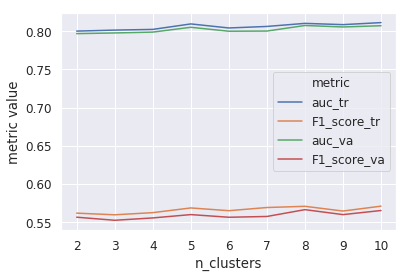

In [169]:
sns.set(font_scale=1.1)
metric1 = metric.melt('n_clusters', var_name='metric',  value_name='metric value')
sns.lineplot(x='n_clusters', y='metric value', hue='metric', data=metric1)
plt.xticks(np.arange(min(metric1['n_clusters']), max(metric1['n_clusters'])+1, 1.0))
#plt.title("metrics among different clusters")